In [1]:
# HACKATHON: SHINKASEN TRAVEL EXPERIENCE
## Gabriel Bisco Reinato
### Version 2.00.0 
#### Last updated on 11-4-2024

# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from keras.callbacks import EarlyStopping

# Tensorflow
from keras import backend
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
keras.backend.clear_session()

In [3]:
# Function to train models
# takes in an array of models as input parameter and training and testing data
# Returns array of model weights and history for ensemble
def train_models(models, x_train, y_train):
 history_list = []
 for model in models:
    print(f"Training: {model}")

    # Train the model
    history = model.fit(x_train, y_train, 
        epochs=35, batch_size=32, validation_split=0.2, 
        callbacks=[EarlyStopping(patience=7, restore_best_weights=True)], 
        verbose=1)
    history_list.append(history)
    
    # Plot training and validation accuracy
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
    

 return history_list

In [4]:
 # Evaluate the model on the test data
def models_weights(models, x_test, y_test):
    model_weights = []
    for model in models:
        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
        model_weights.append(test_accuracy)
    
        print(f"Model {model} Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
        print("-" * 50)
    return model_weights

In [5]:
# Functions to create models

# 1 layer model
# Needs shape of data, number of neurons per layer, and desired dropout rate
# Returns model
def model_1_layer(input_shape, units,dropout_rate):
    inputs = Input(shape=(input_shape,))
    x = Dense(units, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 2 layers model
# Needs shape of data, number of neurons per layer, and desired dropout rate
# Returns model
def model_2_layer(input_shape, units,dropout_rate):
    inputs = Input(shape=(input_shape,))
    x = Dense(units, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(units*2, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 3 layers model
# Needs shape of data, number of neurons per layer, and desired dropout rate
# Returns model
def model_3_layer(input_shape, units,dropout_rate):
    inputs = Input(shape=(input_shape,))
    x = Dense(units, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(units*2, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units*4, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 4 layers model
# Needs shape of data, number of neurons per layer, and desired dropout rate
# Returns model
def model_4_layer(input_shape, units,dropout_rate):
    inputs = Input(shape=(input_shape,))
    x = Dense(units, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(units*2, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units*4, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units*8, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 5 layers model
# Needs shape of data, number of neurons per layer, and desired dropout rate
# Returns model
def model_5_layer(input_shape, units,dropout_rate):
    inputs = Input(shape=(input_shape,))
    x = Dense(units, activation='relu')(inputs)
    x = Dropout(dropout_rate)(x)
    x = Dense(units*2, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units*4, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units*8, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(units*16, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
def ensemble_predictions(models, model_weights, x_test):
    # Generate predictions for each model
    predictions = np.array([model.predict(x_test) for model in models])

    # Check shape of predictions
    print(f"Predictions shape (before weighting): {predictions.shape}")

    # Normalize model weights for the ensemble
    model_weights_local = np.array(model_weights) / np.sum(model_weights)
    
    # Weighted sum of predictions
    weighted_predictions = np.tensordot(predictions, model_weights_local, axes=((0), (0)))

    # Print shape after weighting
    print(f"Weighted predictions shape: {weighted_predictions.shape}")

    return weighted_predictions

In [7]:
def ensemble_accuracy(weighted_predictions, y_test):
    # Convert predictions to binary class labels by rounding
    predicted_labels = np.round(weighted_predictions).flatten()
    
    # Calculate accuracy by comparing with y_test
    accuracy = np.mean(predicted_labels == y_test)
    return accuracy

In [8]:
# Assign directory path
directory_path = os.getcwd()
# Print current directory
print(directory_path)

# Assign file names
file_name = [f for f in os.listdir('.') if f.endswith('.csv')]
# Sort the files in decreasing alphabetical order
file_name = sorted(file_name, reverse=True)
# Print csv files 
print(file_name)

C:\Users\gbisc\Documents\hackathon
['Traveldata_train.csv', 'Traveldata_test.csv', 'Surveydata_train.csv', 'Surveydata_test.csv']


In [9]:
for file in file_name:
    df = pd.read_csv(os.path.join(directory_path, file))
    print(file)
    print(f"\nShape: {df.shape}")
    print("\nNAN Count:")
    print(df.isnull().sum())

Traveldata_train.csv

Shape: (94379, 9)

NAN Count:
ID                            0
Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
dtype: int64
Traveldata_test.csv

Shape: (35602, 9)

NAN Count:
ID                            0
Gender                       30
Customer_Type              3383
Age                          11
Type_Travel                3448
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      29
Arrival_Delay_in_Mins       123
dtype: int64
Surveydata_train.csv

Shape: (94379, 17)

NAN Count:
ID                            0
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Servi

In [10]:
# Data extraction

# Read and merge sets

# Initialize empty lists to hold DataFrames for train and test
train_dataframes = []
test_dataframes = []

# Read each CSV file and append to the respective list with error handling
for file_name in file_name:
    try:
        df = pd.read_csv(os.path.join(directory_path, file_name))

        if 'Surveydata' in file_name:
            df = df.drop(columns=['ID'], errors='ignore')
        
        # Check if the file is train or test and append to the appropriate list
        if 'train' in file_name:
            train_dataframes.append(df)
        elif 'test' in file_name:
            test_dataframes.append(df)

    # Exception errors
    except FileNotFoundError:
        print(f"Error: The file '{file_name}' was not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{file_name}' is empty.")
    except pd.errors.ParserError:
        print(f"Error: The file '{file_name}' could not be parsed.")
    except Exception as e:
        print(f"An unexpected error occurred while reading '{file_name}': {e}")

# Combine Survey and Travel data for training
if train_dataframes:  # Only proceed if there are training DataFrames
    train_df = pd.concat([train_dataframes[0], train_dataframes[1]], axis=1)
else:
    train_df = pd.DataFrame()  # Empty DataFrame if none found

# Combine Survey and Travel data for testing
if test_dataframes:  # Only proceed if there are testing DataFrames
   test_df = pd.concat([test_dataframes[0], test_dataframes[1]], axis=1)
else:
    test_df = pd.DataFrame()  # Empty DataFrame if none found

In [11]:
# Check for NaN or null values in each column
# Display the counts
print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())

ID                            0
Gender                       77
Customer_Type              8951
Age                          33
Type_Travel                9226
Travel_Class                  0
Travel_Distance               0
Departure_Delay_in_Mins      57
Arrival_Delay_in_Mins       357
Overall_Experience            0
Seat_Comfort                 61
Seat_Class                    0
Arrival_Time_Convenient    8930
Catering                   8741
Platform_Location            30
Onboard_Wifi_Service         30
Onboard_Entertainment        18
Online_Support               91
Ease_of_Online_Booking       73
Onboard_Service            7601
Legroom                      90
Baggage_Handling            142
CheckIn_Service              77
Cleanliness                   6
Online_Boarding               6
dtype: int64

ID                            0
Gender                       30
Customer_Type              3383
Age                          11
Type_Travel                3448
Travel_Class              

In [12]:
# Data manipulation
# Droping trivial columns
# Droping trivial columns
train_df = train_df.drop(['ID'], axis = 1)
id_column = test_df.pop('ID') # Storing ID into variable for csv output file

# Defining numerical columns 
num_cols = ['Age','Travel_Distance','Departure_Delay_in_Mins','Arrival_Delay_in_Mins']
# Creating categorical variables 
cat_cols = ['Seat_Comfort', 'Seat_Class',
       'Arrival_Time_Convenient', 'Catering', 'Platform_Location',
       'Onboard_Wifi_Service', 'Onboard_Entertainment', 'Online_Support',
       'Ease_of_Online_Booking', 'Onboard_Service', 'Legroom',
       'Baggage_Handling', 'CheckIn_Service', 'Cleanliness', 'Online_Boarding',
       'Gender', 'Customer_Type','Type_Travel', 'Travel_Class']

# Defining target variable
target_var = 'Overall_Experience'


In [13]:
# convert numerical data into categorical data
# definning bins and labels
# age
age_bins = [0, 15, 30, 45, 60, 100]
age_labels = ['0-15', '16-30', '31-45', '46-60', '61+']
# delay
delay_bins = [0, 10, 20, 30, 40, 50, 60, 1600]
delay_labels = ['0-10 min', '11-20 min', '21-30 min', '31-40 min', '41-50 min','51-60 min', '60+ min']
# trip distance
dist_bins = [0, 1000, 2000, 3000, 4000, 5000, 7000]
dist_labels = ['0-1000 km', '1001-2000 km', '2001-3000 km', '3001-4000 km', '4001-5000 km', '5001+ km']

# Training Data
# Converting delays
train_df['Arrival_Delay_in_Mins'] = pd.cut(train_df['Arrival_Delay_in_Mins'], bins=delay_bins, labels=delay_labels, right=True)
train_df['Departure_Delay_in_Mins'] = pd.cut(train_df['Departure_Delay_in_Mins'], bins=delay_bins, labels=delay_labels, right=True)
# Converting distance
train_df['Travel_Distance'] = pd.cut(train_df['Travel_Distance'], bins=dist_bins, labels=dist_labels, right=True)
# Converting age
train_df['Age'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels, right=True)

# Test Data
# Converting delays
test_df['Arrival_Delay_in_Mins'] = pd.cut(test_df['Arrival_Delay_in_Mins'], bins=delay_bins, labels=delay_labels, right=True)
test_df['Departure_Delay_in_Mins'] = pd.cut(test_df['Departure_Delay_in_Mins'], bins=delay_bins, labels=delay_labels, right=True)
# Converting distance
test_df['Travel_Distance'] = pd.cut(test_df['Travel_Distance'], bins=dist_bins, labels=dist_labels, right=True)
# Converting age
test_df['Age'] = pd.cut(test_df['Age'], bins=age_bins, labels=age_labels, right=True)

In [14]:
# Shuffle the DataFrame (optional but recommended for randomness)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [15]:
# Accounting for NaN values
# Filling unkowns on the target variable by nearest neighbor
imputer = KNNImputer(n_neighbors=4)
train_df[[target_var]] = imputer.fit_transform(train_df[[target_var]])

# Separating target variable
target_list = train_df.pop(target_var)

In [16]:
# Convert all NaN values for unkowns
# Train data
for col in train_df.columns:
    if train_df[col].isnull().sum() > 0:
        if pd.api.types.is_categorical_dtype(train_df[col]): 
            # Add 'Unknown' to the categories if it's not already there
            if 'Unknown' not in train_df[col].cat.categories:
                train_df[col] = train_df[col].cat.add_categories('Unknown')
            train_df[col].fillna('Unknown', inplace=True)
        else:
            train_df[col].fillna('Unknown', inplace=True)

# Test data
for col in test_df.columns:
    if test_df[col].isnull().sum() > 0:
        if pd.api.types.is_categorical_dtype(test_df[col]): 
            # Add 'Unknown' to the categories if it's not already there
            if 'Unknown' not in test_df[col].cat.categories:
                test_df[col] = test_df[col].cat.add_categories('Unknown')
            test_df[col].fillna('Unknown', inplace=True)
        else:
            test_df[col].fillna('Unknown', inplace=True)

In [17]:
# Check for NaN or null values in each column
# Display the counts
print(train_df.isnull().sum())
print()
print(test_df.isnull().sum())

Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
Seat_Comfort               0
Seat_Class                 0
Arrival_Time_Convenient    0
Catering                   0
Platform_Location          0
Onboard_Wifi_Service       0
Onboard_Entertainment      0
Online_Support             0
Ease_of_Online_Booking     0
Onboard_Service            0
Legroom                    0
Baggage_Handling           0
CheckIn_Service            0
Cleanliness                0
Online_Boarding            0
dtype: int64

Gender                     0
Customer_Type              0
Age                        0
Type_Travel                0
Travel_Class               0
Travel_Distance            0
Departure_Delay_in_Mins    0
Arrival_Delay_in_Mins      0
Seat_Comfort               0
Seat_Class                 0
Arrival_Time_Convenient    0


In [18]:
# Formatting data
# Separating target data
Y = target_list.copy()
X = train_df.copy()

# Cat formatting
X = pd.get_dummies(X, columns=X.columns, drop_first=True)

In [19]:
# Splitting the data for method effectiveness - 80-20 split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state = 1, stratify = Y)

# Print variables shapes and head
print(x_train.head(1))
print()
print(y_train.shape)
print(x_train.shape)

       Gender_Male  Gender_Unknown  Customer_Type_Loyal Customer  \
85502        False           False                          True   

       Customer_Type_Unknown  Age_16-30  Age_31-45  Age_46-60  Age_61+  \
85502                  False      False       True      False    False   

       Age_Unknown  Type_Travel_Personal Travel  ...  Cleanliness_Good  \
85502        False                        False  ...              True   

       Cleanliness_Needs Improvement  Cleanliness_Poor  Cleanliness_Unknown  \
85502                          False             False                False   

       Online_Boarding_Excellent  Online_Boarding_Extremely Poor  \
85502                       True                           False   

       Online_Boarding_Good  Online_Boarding_Needs Improvement  \
85502                 False                              False   

       Online_Boarding_Poor  Online_Boarding_Unknown  
85502                 False                    False  

[1 rows x 115 columns]

(

Training: <keras.engine.functional.Functional object at 0x0000029A0A11FB80>
Epoch 1/35
1888/1888 [==============================] - 3s 1ms/step - loss: 0.2624 - accuracy: 0.8881 - val_loss: 0.1929 - val_accuracy: 0.9205
Epoch 2/35
1888/1888 [==============================] - 2s 1ms/step - loss: 0.1770 - accuracy: 0.9266 - val_loss: 0.1550 - val_accuracy: 0.9336
Epoch 3/35
1888/1888 [==============================] - 2s 1ms/step - loss: 0.1531 - accuracy: 0.9366 - val_loss: 0.1434 - val_accuracy: 0.9380
Epoch 4/35
1888/1888 [==============================] - 2s 1ms/step - loss: 0.1402 - accuracy: 0.9416 - val_loss: 0.1340 - val_accuracy: 0.9414
Epoch 5/35
1888/1888 [==============================] - 2s 1ms/step - loss: 0.1327 - accuracy: 0.9448 - val_loss: 0.1304 - val_accuracy: 0.9429
Epoch 6/35
1888/1888 [==============================] - 2s 1ms/step - loss: 0.1263 - accuracy: 0.9479 - val_loss: 0.1267 - val_accuracy: 0.9423
Epoch 7/35
1888/1888 [==============================] - 2s 1

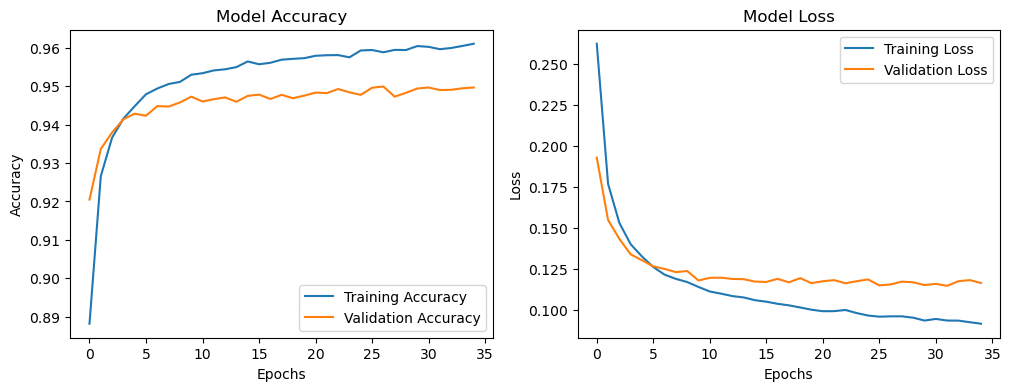

Training: <keras.engine.functional.Functional object at 0x0000029A0A1BE970>
Epoch 1/35
1888/1888 [==============================] - 3s 1ms/step - loss: 0.2702 - accuracy: 0.8854 - val_loss: 0.1815 - val_accuracy: 0.9256
Epoch 2/35
1888/1888 [==============================] - 2s 1ms/step - loss: 0.1823 - accuracy: 0.9237 - val_loss: 0.1554 - val_accuracy: 0.9358
Epoch 3/35
1888/1888 [==============================] - 2s 1ms/step - loss: 0.1616 - accuracy: 0.9333 - val_loss: 0.1457 - val_accuracy: 0.9386
Epoch 4/35
1888/1888 [==============================] - 2s 1ms/step - loss: 0.1485 - accuracy: 0.9373 - val_loss: 0.1365 - val_accuracy: 0.9417
Epoch 5/35
1888/1888 [==============================] - 2s 1ms/step - loss: 0.1434 - accuracy: 0.9398 - val_loss: 0.1319 - val_accuracy: 0.9433
Epoch 6/35
1888/1888 [==============================] - 2s 1ms/step - loss: 0.1372 - accuracy: 0.9429 - val_loss: 0.1260 - val_accuracy: 0.9454
Epoch 7/35
1888/1888 [==============================] - 2s 1

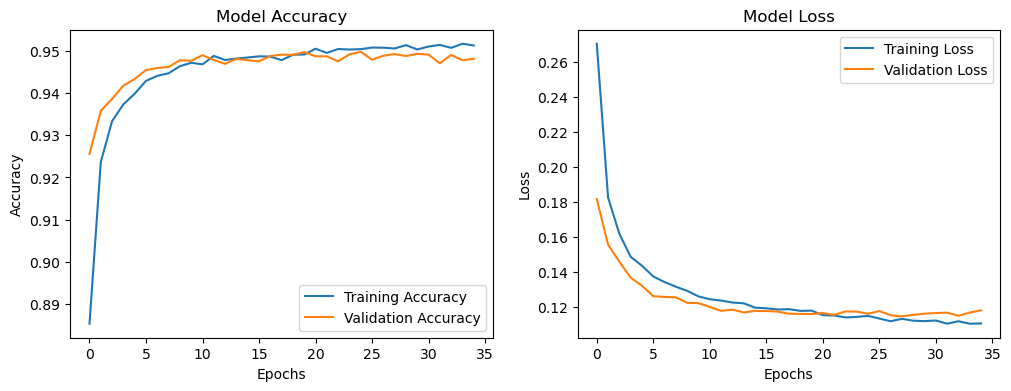

Training: <keras.engine.functional.Functional object at 0x0000029A0A216B20>
Epoch 1/35
1888/1888 [==============================] - 4s 2ms/step - loss: 0.2711 - accuracy: 0.8805 - val_loss: 0.1788 - val_accuracy: 0.9240
Epoch 2/35
1888/1888 [==============================] - 3s 2ms/step - loss: 0.1796 - accuracy: 0.9252 - val_loss: 0.1494 - val_accuracy: 0.9368
Epoch 3/35
1888/1888 [==============================] - 3s 2ms/step - loss: 0.1605 - accuracy: 0.9324 - val_loss: 0.1392 - val_accuracy: 0.9403
Epoch 4/35
1888/1888 [==============================] - 3s 2ms/step - loss: 0.1491 - accuracy: 0.9383 - val_loss: 0.1316 - val_accuracy: 0.9421
Epoch 5/35
1888/1888 [==============================] - 3s 2ms/step - loss: 0.1405 - accuracy: 0.9410 - val_loss: 0.1303 - val_accuracy: 0.9436
Epoch 6/35
1888/1888 [==============================] - 3s 2ms/step - loss: 0.1380 - accuracy: 0.9421 - val_loss: 0.1256 - val_accuracy: 0.9442
Epoch 7/35
1888/1888 [==============================] - 3s 2

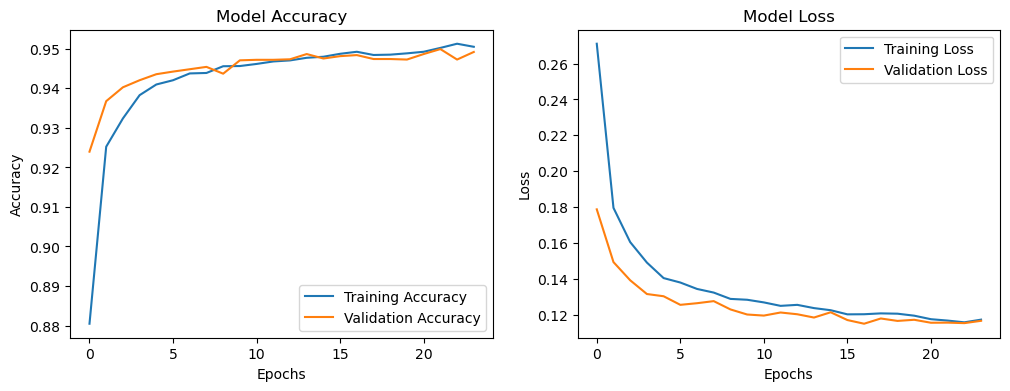

Training: <keras.engine.functional.Functional object at 0x0000029A0A26ED00>
Epoch 1/35
1888/1888 [==============================] - 4s 2ms/step - loss: 0.2864 - accuracy: 0.8763 - val_loss: 0.1834 - val_accuracy: 0.9223
Epoch 2/35
1888/1888 [==============================] - 4s 2ms/step - loss: 0.1913 - accuracy: 0.9211 - val_loss: 0.1540 - val_accuracy: 0.9365
Epoch 3/35
1888/1888 [==============================] - 4s 2ms/step - loss: 0.1690 - accuracy: 0.9305 - val_loss: 0.1456 - val_accuracy: 0.9388
Epoch 4/35
1888/1888 [==============================] - 4s 2ms/step - loss: 0.1572 - accuracy: 0.9355 - val_loss: 0.1399 - val_accuracy: 0.9409
Epoch 5/35
1888/1888 [==============================] - 4s 2ms/step - loss: 0.1522 - accuracy: 0.9371 - val_loss: 0.1335 - val_accuracy: 0.9431
Epoch 6/35
1888/1888 [==============================] - 4s 2ms/step - loss: 0.1468 - accuracy: 0.9378 - val_loss: 0.1294 - val_accuracy: 0.9452
Epoch 7/35
1888/1888 [==============================] - 4s 2

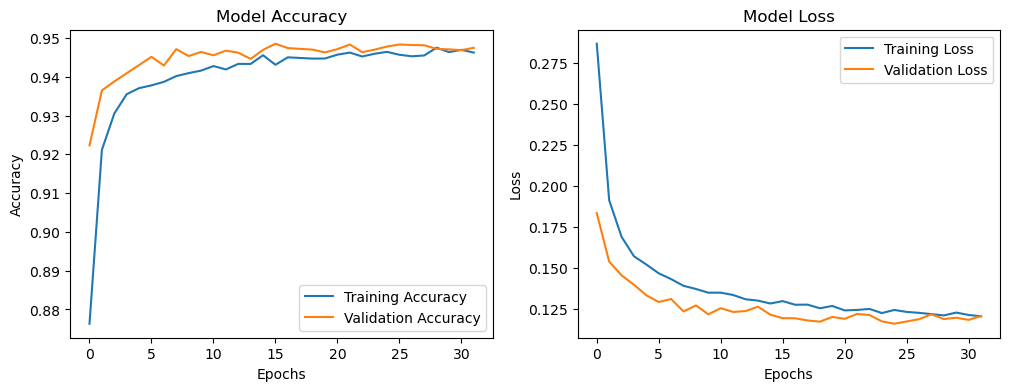

Training: <keras.engine.functional.Functional object at 0x0000029A0A2867F0>
Epoch 1/35
1888/1888 [==============================] - 5s 2ms/step - loss: 0.3403 - accuracy: 0.8489 - val_loss: 0.2264 - val_accuracy: 0.9093
Epoch 2/35
1888/1888 [==============================] - 4s 2ms/step - loss: 0.2336 - accuracy: 0.9046 - val_loss: 0.2006 - val_accuracy: 0.9205
Epoch 3/35
1888/1888 [==============================] - 4s 2ms/step - loss: 0.2083 - accuracy: 0.9153 - val_loss: 0.1759 - val_accuracy: 0.9287
Epoch 4/35
1888/1888 [==============================] - 4s 2ms/step - loss: 0.1987 - accuracy: 0.9191 - val_loss: 0.1732 - val_accuracy: 0.9292
Epoch 5/35
1888/1888 [==============================] - 4s 2ms/step - loss: 0.1914 - accuracy: 0.9225 - val_loss: 0.1766 - val_accuracy: 0.9297
Epoch 6/35
1888/1888 [==============================] - 4s 2ms/step - loss: 0.1840 - accuracy: 0.9256 - val_loss: 0.1750 - val_accuracy: 0.9327
Epoch 7/35
1888/1888 [==============================] - 4s 2

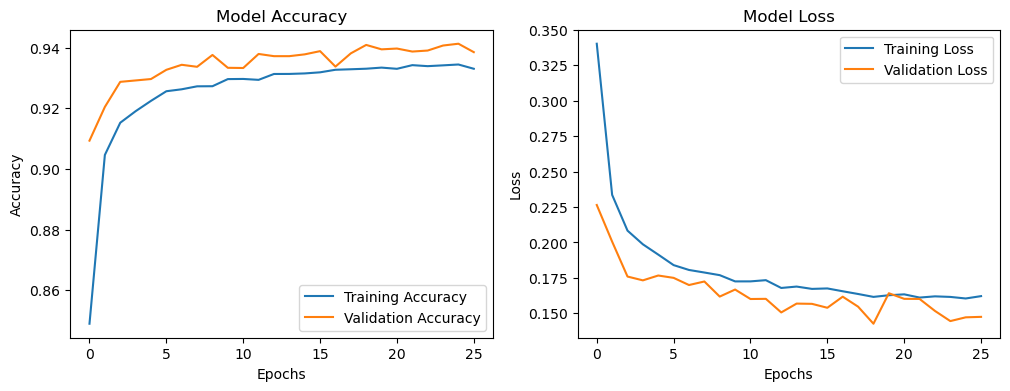

Model <keras.engine.functional.Functional object at 0x0000029A0A11FB80> Test Loss: 0.1190, Test Accuracy: 0.9482
--------------------------------------------------
Model <keras.engine.functional.Functional object at 0x0000029A0A1BE970> Test Loss: 0.1173, Test Accuracy: 0.9479
--------------------------------------------------
Model <keras.engine.functional.Functional object at 0x0000029A0A216B20> Test Loss: 0.1167, Test Accuracy: 0.9484
--------------------------------------------------
Model <keras.engine.functional.Functional object at 0x0000029A0A26ED00> Test Loss: 0.1190, Test Accuracy: 0.9471
--------------------------------------------------
Model <keras.engine.functional.Functional object at 0x0000029A0A2867F0> Test Loss: 0.1434, Test Accuracy: 0.9399
--------------------------------------------------


In [20]:
# Creating models with different configurations
model1 = model_1_layer(X.shape[1],64,0.27)
model2 = model_2_layer(X.shape[1],32,0.27)
model3 = model_3_layer(X.shape[1],32,0.275)
model4 = model_4_layer(X.shape[1],32,0.33)
model5 = model_5_layer(X.shape[1],16,0.33)

# Grouping models
models = [model1, model2, model3, model4, model5]

# Trainning models
models_history = train_models(models, x_train, y_train)

# Get models weights
models_weights = models_weights(models, x_val, y_val)

In [21]:
# Get ensemble predictions and accuracy
weighted_predictions = ensemble_predictions(models, models_weights, x_val)
accuracy = ensemble_accuracy(weighted_predictions, y_val)

# Print accuracy
print(f"Weighted Ensemble Model Test Accuracy: {accuracy:.6f}")

590/590 [==============================] - 1s 911us/step
Predictions shape (before weighting): (5, 18876, 1)
Weighted predictions shape: (18876, 1)
Weighted Ensemble Model Test Accuracy: 0.949036


Training: <keras.engine.functional.Functional object at 0x0000029A0A11FB80>
Epoch 1/35
2360/2360 [==============================] - 3s 1ms/step - loss: 0.1077 - accuracy: 0.9548 - val_loss: 0.0893 - val_accuracy: 0.9622
Epoch 2/35
2360/2360 [==============================] - 3s 1ms/step - loss: 0.1040 - accuracy: 0.9554 - val_loss: 0.0917 - val_accuracy: 0.9607
Epoch 3/35
2360/2360 [==============================] - 3s 1ms/step - loss: 0.1033 - accuracy: 0.9552 - val_loss: 0.0928 - val_accuracy: 0.9593
Epoch 4/35
2360/2360 [==============================] - 3s 1ms/step - loss: 0.1014 - accuracy: 0.9558 - val_loss: 0.0963 - val_accuracy: 0.9584
Epoch 5/35
2360/2360 [==============================] - 3s 1ms/step - loss: 0.1011 - accuracy: 0.9567 - val_loss: 0.0957 - val_accuracy: 0.9577
Epoch 6/35
2360/2360 [==============================] - 3s 1ms/step - loss: 0.1004 - accuracy: 0.9567 - val_loss: 0.0957 - val_accuracy: 0.9584
Epoch 7/35
2360/2360 [==============================] - 3s 1

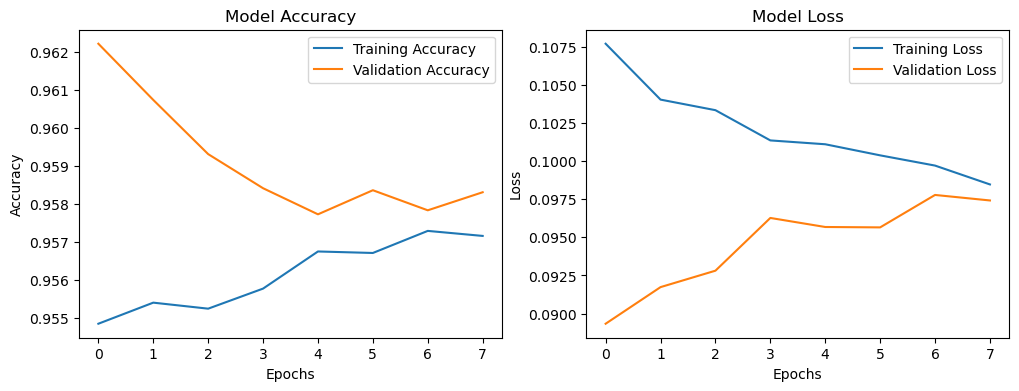

Training: <keras.engine.functional.Functional object at 0x0000029A0A1BE970>
Epoch 1/35
2360/2360 [==============================] - 3s 1ms/step - loss: 0.1212 - accuracy: 0.9467 - val_loss: 0.1023 - val_accuracy: 0.9549
Epoch 2/35
2360/2360 [==============================] - 3s 1ms/step - loss: 0.1195 - accuracy: 0.9474 - val_loss: 0.1012 - val_accuracy: 0.9554
Epoch 3/35
2360/2360 [==============================] - 3s 1ms/step - loss: 0.1186 - accuracy: 0.9484 - val_loss: 0.1019 - val_accuracy: 0.9565
Epoch 4/35
2360/2360 [==============================] - 3s 1ms/step - loss: 0.1180 - accuracy: 0.9482 - val_loss: 0.1007 - val_accuracy: 0.9560
Epoch 5/35
2360/2360 [==============================] - 3s 1ms/step - loss: 0.1162 - accuracy: 0.9491 - val_loss: 0.1038 - val_accuracy: 0.9543
Epoch 6/35
2360/2360 [==============================] - 3s 1ms/step - loss: 0.1143 - accuracy: 0.9495 - val_loss: 0.1032 - val_accuracy: 0.9549
Epoch 7/35
2360/2360 [==============================] - 3s 1

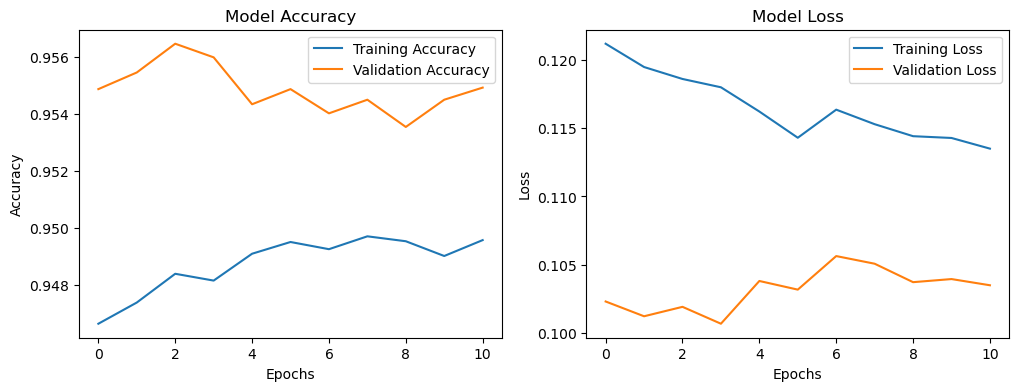

Training: <keras.engine.functional.Functional object at 0x0000029A0A216B20>
Epoch 1/35
2360/2360 [==============================] - 4s 2ms/step - loss: 0.1278 - accuracy: 0.9455 - val_loss: 0.1070 - val_accuracy: 0.9547
Epoch 2/35
2360/2360 [==============================] - 4s 2ms/step - loss: 0.1258 - accuracy: 0.9461 - val_loss: 0.1060 - val_accuracy: 0.9555
Epoch 3/35
2360/2360 [==============================] - 4s 2ms/step - loss: 0.1228 - accuracy: 0.9467 - val_loss: 0.1074 - val_accuracy: 0.9548
Epoch 4/35
2360/2360 [==============================] - 4s 2ms/step - loss: 0.1227 - accuracy: 0.9475 - val_loss: 0.1068 - val_accuracy: 0.9535
Epoch 5/35
2360/2360 [==============================] - 4s 2ms/step - loss: 0.1220 - accuracy: 0.9485 - val_loss: 0.1072 - val_accuracy: 0.9536
Epoch 6/35
2360/2360 [==============================] - 4s 2ms/step - loss: 0.1210 - accuracy: 0.9482 - val_loss: 0.1082 - val_accuracy: 0.9544
Epoch 7/35
2360/2360 [==============================] - 4s 2

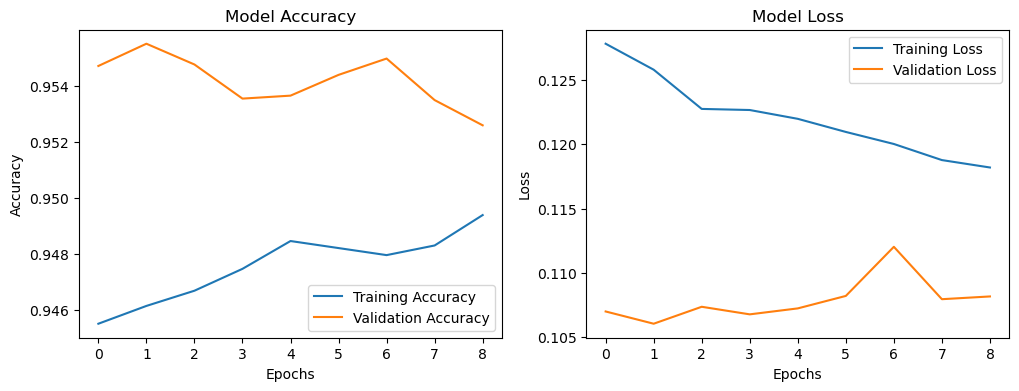

Training: <keras.engine.functional.Functional object at 0x0000029A0A26ED00>
Epoch 1/35
2360/2360 [==============================] - 5s 2ms/step - loss: 0.1321 - accuracy: 0.9423 - val_loss: 0.1073 - val_accuracy: 0.9532
Epoch 2/35
2360/2360 [==============================] - 5s 2ms/step - loss: 0.1289 - accuracy: 0.9432 - val_loss: 0.1067 - val_accuracy: 0.9538
Epoch 3/35
2360/2360 [==============================] - 5s 2ms/step - loss: 0.1289 - accuracy: 0.9435 - val_loss: 0.1099 - val_accuracy: 0.9535
Epoch 4/35
2360/2360 [==============================] - 5s 2ms/step - loss: 0.1270 - accuracy: 0.9431 - val_loss: 0.1062 - val_accuracy: 0.9538
Epoch 5/35
2360/2360 [==============================] - 5s 2ms/step - loss: 0.1262 - accuracy: 0.9442 - val_loss: 0.1043 - val_accuracy: 0.9540
Epoch 6/35
2360/2360 [==============================] - 5s 2ms/step - loss: 0.1271 - accuracy: 0.9439 - val_loss: 0.1083 - val_accuracy: 0.9523
Epoch 7/35
2360/2360 [==============================] - 5s 2

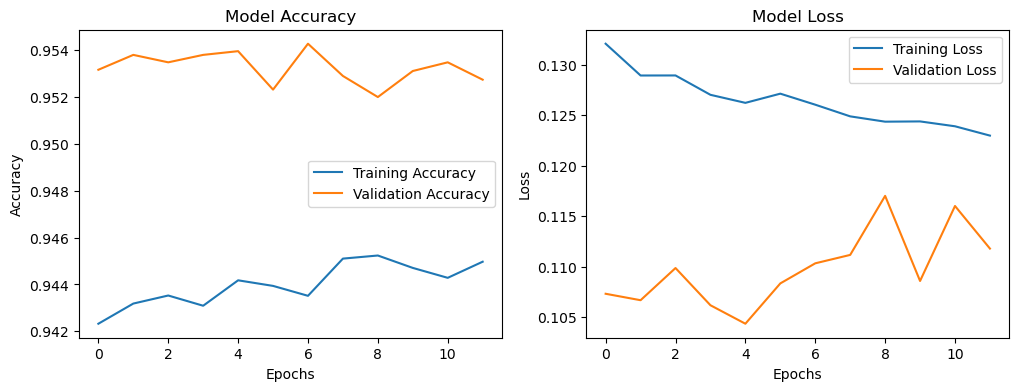

Training: <keras.engine.functional.Functional object at 0x0000029A0A2867F0>
Epoch 1/35
2360/2360 [==============================] - 5s 2ms/step - loss: 0.1690 - accuracy: 0.9309 - val_loss: 0.1603 - val_accuracy: 0.9436
Epoch 2/35
2360/2360 [==============================] - 5s 2ms/step - loss: 0.1663 - accuracy: 0.9311 - val_loss: 0.1540 - val_accuracy: 0.9388
Epoch 3/35
2360/2360 [==============================] - 5s 2ms/step - loss: 0.1654 - accuracy: 0.9326 - val_loss: 0.1518 - val_accuracy: 0.9438
Epoch 4/35
2360/2360 [==============================] - 5s 2ms/step - loss: 0.1655 - accuracy: 0.9318 - val_loss: 0.1440 - val_accuracy: 0.9467
Epoch 5/35
2360/2360 [==============================] - 5s 2ms/step - loss: 0.1635 - accuracy: 0.9323 - val_loss: 0.1644 - val_accuracy: 0.9361
Epoch 6/35
2360/2360 [==============================] - 5s 2ms/step - loss: 0.1621 - accuracy: 0.9331 - val_loss: 0.1533 - val_accuracy: 0.9389
Epoch 7/35
2360/2360 [==============================] - 5s 2

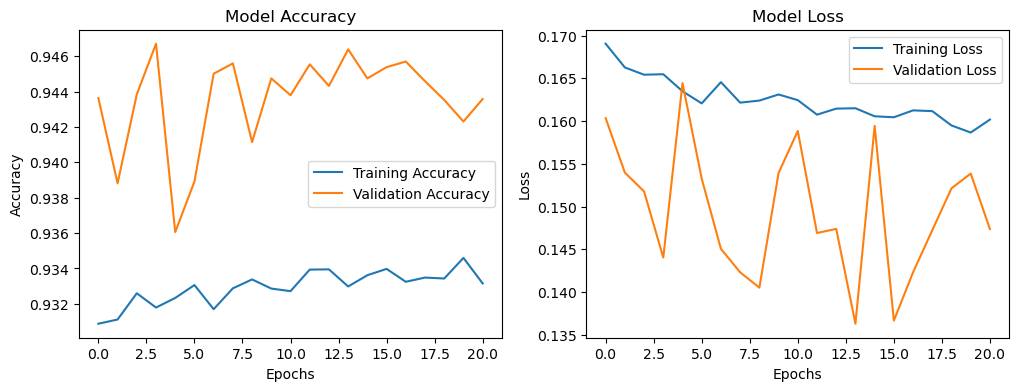

In [22]:
# Train model with entire dataset
# New data split
x_train = train_df.copy()
y_train = target_list.copy()
x_test = test_df.copy()

x_train = pd.get_dummies(x_train, columns=x_train.columns, drop_first=True)
x_test = pd.get_dummies(x_test, columns=x_test.columns, drop_first=True)

# Align Data
x_train, x_test = x_train.align(x_test, join='left', axis=1, fill_value=0)

# Train models on the new data
models_history = train_models(models, x_train, y_train)

In [23]:
# Get ensemble predictions
x_test = x_test.astype(int)
weighted_predictions = ensemble_predictions(models, models_weights, x_test)

1113/1113 [==============================] - 1s 919us/step
Predictions shape (before weighting): (5, 35602, 1)
Weighted predictions shape: (35602, 1)


In [24]:
# Create a DataFrame
df = pd.DataFrame({
    "ID": id_column,
    "Overall_Experience": np.round(weighted_predictions).flatten(),
})

# Write predictions to csv output file
df.to_csv("DL Model Predictions.csv", index=False)